In [1]:
import arviz as az

In [2]:
from util import stan_cache

In [3]:
update_mpl_setting()

In [4]:
np.random.seed(12345)

In [5]:
uniform_pvals = [0.33, 0.33, 0.33]

In [6]:
def uniform(n):
    k = n // 3
    ret = [k, k, k]
    for i in range(n - k*3):
        t = np.argmax(np.random.multinomial(n=1, pvals=[0.33, 0.33, 0.33]))
        ret[t] += 1
        
    return ret

In [7]:
N = 10000
k1, k2, k3 = np.random.multinomial(n=N, pvals=uniform_pvals)

In [8]:
a = np.random.multinomial(n=k1, pvals=[0.7, 0.2, 0.1])
b = np.random.multinomial(n=k2, pvals=[0.2, 0.5, 0.3])
c = uniform(k3)

In [9]:
colnames = ["Meat", "Fish", "Cheese"]
indexnames = ["Red", "White", "Rose"]

In [10]:
df = pd.DataFrame(np.vstack((a, b, c)), columns=colnames, index=indexnames)
df

,Meat,Fish,Cheese
Red,2373,632,299
White,658,1672,983
Rose,1129,1127,1127


In [11]:
model = """
data { 
    int<lower=1> g;
    int<lower=0> N;
    int<lower=0> n[g, g];
}
transformed data {
    int<lower=0> vectorized_n[g*g];

    for (i in 1:g) {
        for (j in 1:g) {
            vectorized_n[(i - 1)*g + j] = n[i, j];
        }
    }
}
parameters {
    simplex[g*g] vectorized_p;
}
transformed parameters {
    real<lower=0, upper=1> p[g, g];

    for (i in 1:g) {
        for (j in 1:g) {
            p[i, j] = vectorized_p[(i - 1)*g + j];
        }
    }
}
model {
    vectorized_n ~ multinomial(vectorized_p);
}
generated quantities {
    real marginal_prob_r[g];
    real marginal_prob_c[g];
    real pearson_residual[g, g];
    real pearson_residual_positive[g, g];
    real pearson_residual_negative[g, g];
    real cramers_V = 0;

    for (i in 1:g) {
        marginal_prob_r[i] = 0;
        marginal_prob_c[i] = 0;
    }

    for (i in 1:g) {
        for (j in 1:g) {
            marginal_prob_r[i] += p[i, j];
            marginal_prob_c[j] += p[i, j];
        }
    }

    for (i in 1:g) {
        for (j in 1:g) {
            pearson_residual[i, j] = (p[i, j] - marginal_prob_r[i] * marginal_prob_c[j]) / sqrt(marginal_prob_r[i] * marginal_prob_c[j]);
            cramers_V += pow(pearson_residual[i, j], 2);
            pearson_residual_positive[i, j] = pearson_residual[i, j] > 0 ? 1 : 0;
            pearson_residual_negative[i, j] = !(pearson_residual_positive[i, j]);
        }
    }
    cramers_V = sqrt(cramers_V / (g - 1));
}
"""

In [12]:
data = {
    "g": 3,
    "N": N,
    "n": df.values
}

sm = stan_cache(model_code=model)
params = sm.sampling(data=data, iter=6000, warmup=1000)

In [13]:
def show(target):
    ret = []
    for i in range(3):
        for j in range(3):
            ret.append(np.mean(params[target][:, i, j]))
    df = pd.DataFrame(np.array(ret).reshape(3, 3))
    df.columns = colnames
    df.index = indexnames
    return df

In [14]:
def plot(target):
    for i in range(3):
        for j in range(3):
            sns.distplot(params[target][:, i, j], label=f"{target}: {i}-{j}")
    plt.legend()

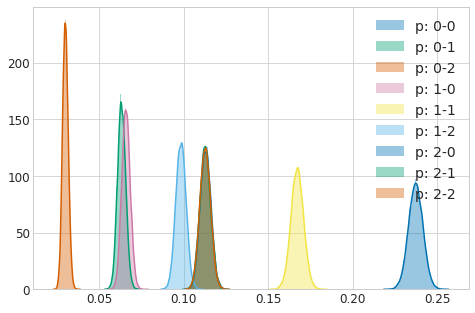

In [15]:
plot("p")

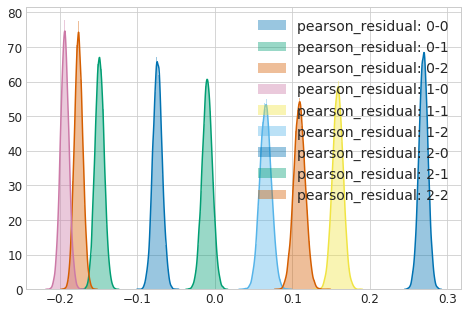

In [16]:
plot("pearson_residual")

In [17]:
show("p")

,Meat,Fish,Cheese
Red,0.237195,0.063224,0.029984
White,0.065824,0.167152,0.098327
Rose,0.112903,0.112688,0.112705


In [18]:
show("pearson_residual")

,Meat,Fish,Cheese
Red,0.269139,-0.148874,-0.175924
White,-0.193876,0.158669,0.065387
Rose,-0.074113,-0.009889,0.109157


In [19]:
show("pearson_residual_positive")

,Meat,Fish,Cheese
Red,1.0,0.0000,0.0
White,0.0,1.0000,1.0
Rose,0.0,0.0698,1.0


In [20]:
show("pearson_residual_negative")

,Meat,Fish,Cheese
Red,0.0,1.0000,1.0
White,1.0,0.0000,0.0
Rose,1.0,0.9302,0.0


In [21]:
pd.Series(params["cramers_V"]).to_frame().describe().rename(columns={0: "cramers_V"}).T

,count,mean,std,min,25%,50%,75%,max
cramers_V,20000.0,0.324328,0.006364,0.29783,0.320083,0.324373,0.328593,0.350334


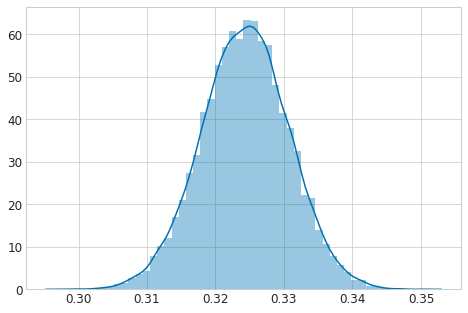

In [22]:
sns.distplot(params["cramers_V"])